In [1]:
import numpy as np

from pathlib import Path
from ase.io import read

from qtpyt.tools import remove_pbc
from qtpyt.lo import tools as lot
from qtpyt.surface import principallayer
from qtpyt.basis import Basis
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.selfenergy import SelfEnergy
import tqdm
from qtpyt.base import intgreenfunction
from gpaw import restart
from qtpyt.surface.tools import prepare_leads_matrices

### Helper functions

In [2]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


In [3]:
# define the extend coupling function, which we shall use twice
def extend_coupling(selfenergy, nbf_m, id='left'):
    nbf_i = selfenergy.nbf_i
    h_im = np.zeros((nbf_i, nbf_m), complex)
    s_im = np.zeros_like(h_im)
    if id == 'left':
        h_im[:,:nbf_i] = selfenergy.h_im
        s_im[:,:nbf_i] = selfenergy.s_im
    else:
        h_im[:,-nbf_i:] = selfenergy.h_im
        s_im[:,-nbf_i:] = selfenergy.s_im
    selfenergy.h_im = h_im
    selfenergy.s_im = s_im
    selfenergy.sigma_mm = np.zeros((nbf_m, nbf_m), complex)

### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

H_lcao, S_lcao = np.load("dft/device/hs_cc_k.npy")


In [6]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')
basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

nodes = [0,810,1116,1278,1584,2394]

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
eta = 1e-3


In [7]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices) This is here because tests suggest that
# this step needs to be done prior to removing PBC in the aligning Hamiltonian

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao)
remove_pbc(device_basis, S_lcao)

selfenergies = [None, None]
selfenergies[0] = principallayer.PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
selfenergies[1] = principallayer.PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')


In [8]:
# extract indices of the active space which include C and N atoms
active = np.where(np.isin(device_atoms.symbols,['C','N']))[0]

idx_active = device_basis[active].get_indices().reshape(active.size,13)
idx_lo_pz = idx_active[:,3].copy()  # what is this? it seems to be the indices of the pz orbitals in the los basis
iaopz = idx_active[:,2].copy()  # what is this?
# get embedding space as the difference
idx_embedding = np.setdiff1d(range(H_lcao.shape[-1]), idx_lo_pz)


In [9]:
# get subdiagonalization matrix
Us, eig = lot.subdiagonalize_atoms(device_basis, H_lcao[0], S_lcao[0], a=active)

# make sure that the projection onto the original pz AOs has the same sign for all pz LOs
# I am still not sure if this step is correct but now at least I understand the logic behind it
flip_sign = np.where(Us[iaopz,idx_lo_pz]<0.)[0]
for i in flip_sign:
    Us[np.ix_(idx_active[i],idx_active[i])] *= -1

#get subdiagonalized pair
H_subdiagonal = lot.rotate_matrix(H_lcao[0], Us)
S_subdiagonal = lot.rotate_matrix(S_lcao[0], Us)

In [10]:
selfenergies = [None, None]
selfenergies[0] = principallayer.PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
selfenergies[1] = principallayer.PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# orthogonalize subspaces, hs_mm (active) and hs_ii (embedding) as usual
hs_mm, hs_ii, hs_im, U = lot.extract_orthogonal_subspaces(H_subdiagonal, S_subdiagonal, idx_lo_pz)

# # expand embedding self-enegies matrix with dimension nbf_pl x nbf_pl to matrix with dimension nbf_i x nbf_i
# nbf_i = hs_ii[0].shape[0]
# extend_coupling(selfenergies[0], nbf_i)
# extend_coupling(selfenergies[1], nbf_i, id='right')


In [11]:
# get \Sigma_A from Eq. (B7) that is nbf_m x nbf_m (i.e., size of the active space)
self_mm = SelfEnergy(hs_ii, hs_im, [(slice(None), selfenergies[0]),(slice(None), selfenergies[1])])

# get G_A with the \Sigma_L and \Sigma_R leads' self-energies
gf = GreenFunction(hs_mm[0], hs_mm[1])

# add the embedding self-energy to G_A using the class for the interacting Green's function
igf = intgreenfunction.GreenFunction(gf, (slice(None), self_mm))

In [12]:
# calculate transmission
energies = np.linspace(-2.5,2.5,1)
T_e = np.zeros_like(energies)
for e, energy in enumerate(energies):
    T_e[e] = igf.get_transmission(energy)

UnboundLocalError: local variable 'sigma' referenced before assignment

In [ ]:
from matplotlib import pyplot as plt

E_ref, T_ref = np.load("published_reference/transmission/ET_dft.npy")

plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the reference DFT data
plt.plot(E_ref, T_ref, label="references dft", color='blue')

# Plot the computed DFT data
plt.plot(energies, T_e, 'o', label="embedded", color='red')

### What do I need?

1. Compute T(E) from G_active using eqn.B3. This can be done by providing hs_active and sigma_a to a Greensfunction class. hs_active is obtained from extract_orthogonal_subspace.
2. I need to compute sigma_A using eqn. B8 which requires the hs_ae_coupling and Greens function of the embedding region. hs_ae_coupling is obtained from extract_orthogonal_subspace.
3. Embedding Greens function can be obtained by providing hs_embedding and embedded leads self energy to the Greens function class (eqn. B11). Embedded leads self energy needs to be computed using eqn. B12 which requires hs_le_coupling and Greens function for each lead.

Based on the above information, if I were to order the steps chronologically to compute various quantities, it would look like this

1. Get Green's functions for the left and right leads using a Greens's function class.
2. Get the H and S for the coupling between the leads and the embedding region.
3. Use the above matrices to compute the embedded leads self energy sigma_L,R for the left and right leads. This sigma_L,R would have dimensions of the embedding region.
4. Or, alternatively compute directly the sigma_L,R for the left and right using a selfenergy class.
5. Provide hs_embedding and sigma_L,R to a Greensfunction class to compute embedding Green's function G_e.
6. Compute active self energy sigma_a using G_e and hs_ae_coupling using a self energy class.
7. Provide hs_active and sigma_a to Greensfunction class to compute active Green's function G_active
8. Compute T(E) using G_active.get_transmission().
   1. If we were to successfully get to this step of computing transmission functions, there is an issue. If we use the formula given by 
   
   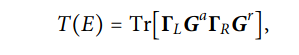
   
   we need gamma_L, G and gamma_R to have the same dimensions. But by the end of step 8, we have a G_active that has the dimensions of the active space while the gamma_L,R have the dimensions of the leads. How do we reconcile this?

### Analyzing the workflow code 

1. `extend_coupling()` is a part of the `deprecated` folder in the code base, while the other parts of the code such as `PrincipalSelfEnergy()` are from the main code base. I could get it to work by calling other functions that are also in the `deprecated` folder but that would require some adjustments to the rest of the code.
2. Build self-energy for left and right lead seems straightforward. Something to keep in mind: `selfenergies[0,1].gammas` will have the dimensions of the leads.
3. Orthogonalize subspaces, `hs_mm` (active) and `hs_ii` (embedding)  in order to extract H and S for the active, embedding and the coupling between them.
4. `extend_coupling` (if it was working) that perhaps executes the step in the equation below (?) and changes the dimensions of selfenergy from that of the leads to that of the embedding. 
   
   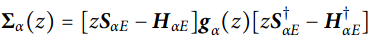
5. Get \Sigma_A from Eq. (B8) that is nbf_m x nbf_m (i.e., size of the active space)
`self_mm = SelfEnergy(hs_ii, hs_im, [(slice(None), selfenergies[0]),(slice(None), selfenergies[1])])`. Need to understand how the `slice(None)` is used to ensure the right implementation to extract the right indices. My rudimentary understanding is that the `selfenergies[0,1]` in this step now have dimensions of the embedding and not the leads, while `self_mm` will have the dimensions of the active space.  

   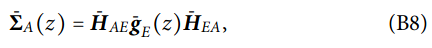

6. Get G_Active. However the information of the \Sigma_L and \Sigma_R leads' self-energies required to compute gamma_L,R for the Landauer formula is missing in the line
`gf = GreenFunction(hs_mm[0], hs_mm[1])`

7. Add the embedding self-energy \Sigma_A to G_A using the class for the interacting Green's function
`igf = intgreenfunction.GreenFunction(gf, (slice(None), self_mm)` (However this function doesn't work. See error above)

8. How do we compute T(E) while also resolving the dimensionality of leads' Gamma and active space Green's function?
